In [1]:
import pandas as pd

df = pd.read_csv('light_stemmed.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15123 entries, 0 to 15122
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   citation  14690 non-null  object
 1   ethics    15123 non-null  object
dtypes: object(2)
memory usage: 236.4+ KB


In [2]:
# Ensure that all citations are strings
df['citation'] = df['citation'].astype(str)

In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Filter classes that have between 50 and 199 instances
class_counts = df['ethics'].value_counts()
underrepresented_classes = class_counts[(class_counts >= 50) & (class_counts < 250)].index

# Filter the DataFrame for these classes
df_underrepresented = df[df['ethics'].isin(underrepresented_classes)]

# Prepare the input and output for oversampling
X = df_underrepresented['citation']  # Features (texts)
y = df_underrepresented['ethics']    # Labels (ethics classes)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Define the oversampling strategy: each class gets between 200 and 250 instances
sampling_strategy = {
    cls: min(300, max(250, class_counts[cls]))
    for cls in underrepresented_classes
}

# Apply SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y)

# Create a new DataFrame with the resampled data
df_resampled = pd.DataFrame({'citation': vectorizer.inverse_transform(X_resampled), 'ethics': y_resampled})

# Combine with the original DataFrame
df_balanced = pd.concat([df, df_resampled]).reset_index(drop=True)

# Display results
print("Original class distribution:")
print(class_counts)
print("\nResampled class distribution:")
print(df_balanced['ethics'].value_counts())


Original class distribution:
ethics
الإفتراء      390
البشاشة       361
الشهامة       334
حفظ اللسان    314
البطر         313
             ... 
التأني         26
رفع الصوت      25
الشكر          20
الفصاحة         5
ethic           1
Name: count, Length: 128, dtype: int64

Resampled class distribution:
ethics
العدل        494
الاحترام     493
الطمع        471
الشجاعة      468
الكبر        457
            ... 
التأني        26
رفع الصوت     25
الشكر         20
الفصاحة        5
ethic          1
Name: count, Length: 128, dtype: int64


In [5]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Filter classes that have between 50 and 199 instances
class_counts = df['ethics'].value_counts()
underrepresented_classes = class_counts[(class_counts >= 50) & (class_counts < 250)].index

# Filter the DataFrame for these classes
df_underrepresented = df[df['ethics'].isin(underrepresented_classes)]

# Prepare the input and output for oversampling
X = df_underrepresented['citation']  # Features (texts)
y = df_underrepresented['ethics']    # Labels (ethics classes)

# Define the oversampling strategy: each class gets between 200 and 250 instances
sampling_strategy = {
    cls: min(300, max(250, class_counts[cls]))
    for cls in underrepresented_classes
}

# Apply RandomOverSampler
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)

# Create a new DataFrame with the oversampled data
df_resampled = pd.DataFrame({'citation': X_resampled.flatten(), 'ethics': y_resampled})

# Combine with the original DataFrame
df_balanced = pd.concat([df, df_resampled]).reset_index(drop=True)

# Display results
print("Original class distribution:")
print(class_counts)
print("\nResampled class distribution:")
print(df_balanced['ethics'].value_counts())

Original class distribution:
ethics
الإفتراء      390
البشاشة       361
الشهامة       334
حفظ اللسان    314
البطر         313
             ... 
التأني         26
رفع الصوت      25
الشكر          20
الفصاحة         5
ethic           1
Name: count, Length: 128, dtype: int64

Resampled class distribution:
ethics
العدل        494
الاحترام     493
الطمع        471
الشجاعة      468
الكبر        457
            ... 
التأني        26
رفع الصوت     25
الشكر         20
الفصاحة        5
ethic          1
Name: count, Length: 128, dtype: int64


In [6]:
class_counts = df_balanced['ethics'].value_counts()

# Filter the classes that appear less than 100 times
classes_to_drop = class_counts[class_counts < 200].index

# Filter the DataFrame to exclude those classes
df = df_balanced[~df_balanced['ethics'].isin(classes_to_drop)]
df['citation'] = df['citation'].astype(str)
# Check the number of classes and data points after filtering
print(f"Classes remaining after filtering: {df['ethics'].nunique()}")
print(f"Number of data points after filtering: {len(df)}")
df.info()

Classes remaining after filtering: 111
Number of data points after filtering: 39063
<class 'pandas.core.frame.DataFrame'>
Index: 39063 entries, 80 to 39622
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   citation  39063 non-null  object
 1   ethics    39063 non-null  object
dtypes: object(2)
memory usage: 915.5+ KB


C:\Users\21656\AppData\Local\Temp\ipykernel_19960\2091100959.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['citation'] = df['citation'].astype(str)


In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


# Data preparation
X = df['citation']
y = df['ethics']

classes = y.unique()
y_binarized = label_binarize(y, classes=classes)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.tolist()
X_test = X_test.tolist()
# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=200)
model.fit(X_train_tfidf, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Additional evaluation metrics
#print("\nClassification Report:")
#print(classification_report(y_test, y_pred))
#y_score = model.predict_proba(X_test_tfidf)


Accuracy: 0.8165877383847434


In [14]:
unseen_example_original = "العدل أساس الحكم الصالح بين الناس."
unseen_example ="عدل اساس حكم صالح بين ناس"
unseen_class = "العدل"  # Correct class for this example

# Transform the unseen example using the trained TF-IDF vectorizer
unseen_example_tfidf = vectorizer.transform([unseen_example])

# Predict the class for the unseen example
predicted_class = model.predict(unseen_example_tfidf)[0]

# Print results
print("Unseen Example Text:")
print(unseen_example_original)
print("\nOriginal Class (Actual):")
print(unseen_class)
print("\nPredicted Class:")
print(predicted_class)

# Compare results
if unseen_class == predicted_class:
    print("\n✅ The prediction is correct!")
else:
    print("\n❌ The prediction is incorrect.")


Unseen Example Text:
العدل أساس الحكم الصالح بين الناس.

Original Class (Actual):
العدل

Predicted Class:
العدل

✅ The prediction is correct!


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data preparation
X = df['citation']
y = df['ethics']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=6000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression model
model = LogisticRegression(max_iter=1300)
model.fit(X_train_tfidf, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.595033917829259


In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data preparation
X = df['citation']
y = df['ethics']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Naive Bayes model
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.5696915397414566


In [8]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data preparation
X = df['citation']
y = df['ethics']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train SVM model
model = SVC(kernel='linear')
model.fit(X_train_tfidf, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.6704210930500448


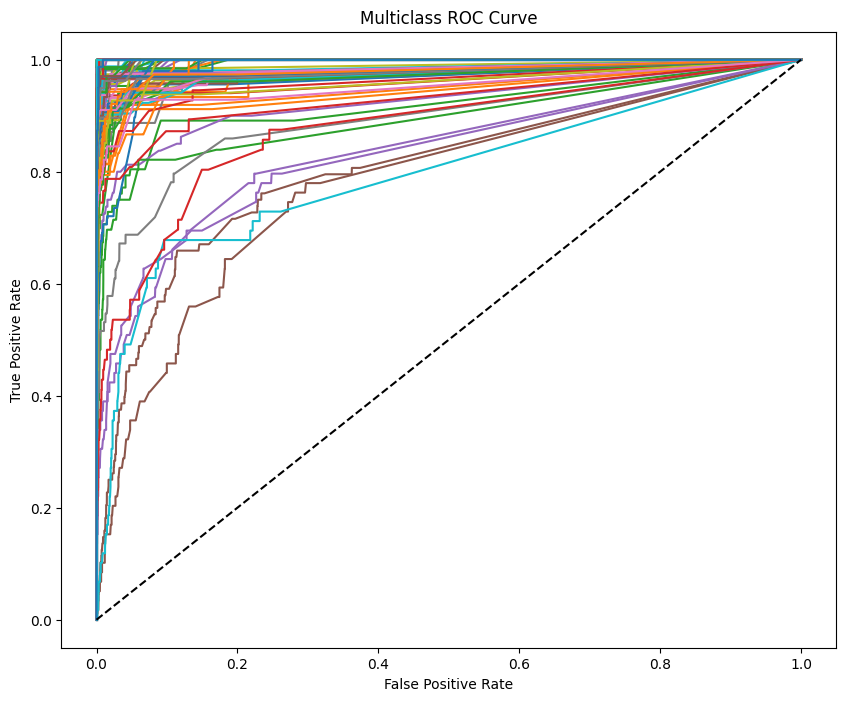

In [29]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output labels
classes = sorted(y.unique())  # List of all class labels
y_test_bin = label_binarize(y_test, classes=classes)

# Compute the decision function or probability scores
y_score = model.predict_proba(X_test_tfidf)

# Plotting the ROC Curve
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Add plot details
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend(loc='lower right')
plt.show()


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data preparation
X = df['citation']
y = df['ethics']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Decision Tree model
model = DecisionTreeClassifier()
model.fit(X_train_tfidf, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.8044285165749392


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Data preparation
X = df['citation']
y = df['ethics']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorizer with more features
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Compute class weights for handling imbalance
classes = y.unique()
class_weights = compute_class_weight('balanced', classes=classes, y=y)
class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

# Define the model with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, class_weight=class_weights_dict)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_tfidf, y_train)

# Best parameters and training the final model
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Evaluate with test data
y_pred = best_rf.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Cross-validation for robustness
cv_scores = cross_val_score(best_rf, X_train_tfidf, y_train, cv=5)
print("Cross-Validation Accuracy: {:.2f}%".format(cv_scores.mean() * 100))


Fitting 3 folds for each of 81 candidates, totalling 243 fits


KeyboardInterrupt: 